# Name: Kelvin Peterson
# Date: 5/3/25
# File: GlassIdentifier.ipynb

# Description: This notebook investigates glass identification using chemical composition data (usually for crimes) from the UCI Machine Learning Repository. By applying data quality checks, feature analysis, and machine learning (Decision Tree), it aims to classify different types of glass based on their chemical properties. The GUI component allows for interactive exploration, searching, and prediction with the trained model. This solution provides insights into how chemical composition affects glass classification and demonstrates the practical application of decision trees for forensic science.

# Folder: 
- GlassIdentifier.ipynb: This notebook to analyze the glass based on chemical composition
- README.TXT: ReadME File with more instructions on how to run the code.

# Installations
There are a lot of installations needed for this notebook to work. These installations are used for the following:

- `pandas` is used for handling and cleaning tabular data (e.g. word counts, metadata).
- `numpy` supports numerical operations like calculating averages and accuracy.
- `matplotlib.pyplot` is used to create visualizations, like clustering dendrograms.
- `sklearn.preprocessing.StandardScaler` scales features so clustering and models work better.
- `sklearn.svm.SVC` builds a Support Vector Machine model for author classification.
- `scipy.cluster.hierarchy.dendrogram` and `linkage` are used for hierarchical clustering of documents.
- `sklearn.model_selection.train_test_split`, `KFold`, and `cross_val_score` are used to train and evaluate models with cross-validation.
- `sklearn.tree.DecisionTreeClassifier` builds a decision tree to classify text authorship.
- `sklearn.metrics.accuracy_score` calculates how well the models are performing.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import tkinter as tk
from tkinter import ttk, scrolledtext
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Load the UCI Glass Identification dataset
This code fetches the dataset from the UCI Machine Learning Repository using the ucimlrepo package. The dataset contains information about different types of glass with their chemical composition. It gets the features of the dataset and then converts it to panda dataframes.

In [10]:
from ucimlrepo import fetch_ucirepo   
# fetch dataset 
glass_identification = fetch_ucirepo(id=42) 
  
# data (as pandas dataframes) 
X = glass_identification.data.features 
y = glass_identification.data.targets 
  
# metadata 
print(glass_identification.metadata) 
  
# variable information 
print(glass_identification.variables) 


{'uci_id': 42, 'name': 'Glass Identification', 'repository_url': 'https://archive.ics.uci.edu/dataset/42/glass+identification', 'data_url': 'https://archive.ics.uci.edu/static/public/42/data.csv', 'abstract': 'From USA Forensic Science Service; 6 types of glass; defined in terms of their oxide content (i.e. Na, Fe, K, etc)', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 214, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Type_of_glass'], 'index_col': ['Id_number'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1987, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5WW2P', 'creators': ['B. German'], 'intro_paper': None, 'additional_info': {'summary': 'Vina conducted a comparison test of her rule-based system, BEAGLE, the nearest-neighbor algorithm, and discriminant analysis.  BEAGLE is a product available through VRS Consulting, In

Then this code starts out with combining features and target for easier data exploration by merging the chemical properties with glass type information into a single dataframe.

# Data Quality Check
After it does the function data_quality_check does a quality check of the data. This function performs comprehensive quality checks on the dataset to identify potential issues. It examines data shape, types, missing values, duplicates, and statistical distributions. It also adds descriptive labels for glass types to improve interpretability.

In [11]:
data = pd.concat([X, y], axis=1)

# Data Quality Check
def data_quality_check(df):
    print("Data Shape:", df.shape)
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nDuplicate Rows:", df.duplicated().sum())
    print("\nSummary Statistics:")
    print(df.describe())
    
    # Class distribution
    print("\nClass Distribution:")
    print(df['Type_of_glass'].value_counts())
    
    # Convert Type_of_glass to string labels for better readability
    glass_type_labels = {
        1: "building_windows_float_processed",
        2: "building_windows_non_float_processed",
        3: "vehicle_windows_float_processed",
        4: "vehicle_windows_non_float_processed",
        5: "containers",
        6: "tableware",
        7: "headlamps"
    }
    df['Glass_Type_Label'] = df['Type_of_glass'].map(glass_type_labels)
    
    return df

# Clean Data
This function identifies outliers in the dataset using the IQR method but does not remove them. Outliers in chemical compositions might be significant indicators of certain glass types, so it would not be smart to remove them from theh code. It also removes non-predictive columns like ID numbers from the analysis dataset. 

In [12]:
def clean_data(df):
    # Make a copy to avoid modifying the original
    df_clean = df.copy()
    
    # Check for outliers using IQR method
    for col in df_clean.select_dtypes(include=[np.number]).columns:
        if col != 'Type_of_glass' and col != 'Id_number':
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            print(f"Outliers in {col}: {((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()}")
    
    # No dropping of outliers as they might be important for certain glass types
    
    # Drop ID column as it's not useful for modeling
    if 'Id_number' in df_clean.columns:
        df_clean = df_clean.drop('Id_number', axis=1)
    
    return df_clean

# Data Visualization
This function creates various visualizations to understand relationships in the data:
- Correlation matrix to show relationships between chemical properties
- Box plots to compare how each property varies across different glass types
- Distribution plots to understand the overall spread of each chemical component

In [13]:
def visualize_data(df):
    # Correlation matrix
    plt.figure(figsize=(12, 10))
    corr = df.select_dtypes(include=[np.number]).drop(['Type_of_glass'], axis=1).corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Box plots for each feature by glass type
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols.remove('Type_of_glass')
    
    for col in numerical_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Glass_Type_Label', y=col, data=df)
        plt.xticks(rotation=90)
        plt.title(f'Distribution of {col} by Glass Type')
        plt.tight_layout()
        plt.show()
    
    # Feature distributions
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols):
        plt.subplot(3, 3, i+1)
        sns.histplot(df[col], kde=True)
        plt.title(col)
    plt.tight_layout()
    plt.show()

# Descision Tree
This function builds and evaluates a decision tree classifier for glass type prediction. It prepares the data by removing non-feature columns, splits it into training and test sets, standardizes the features, trains the model, and evaluates its performance using multiple metrics. It also visualizes the decision tree structure to understand the classification rules.

In [14]:
# Model Building
def build_decision_tree(X_data, y_data):
    # Remove non-feature columns
    features = X_data.drop(['Glass_Type_Label'], axis=1, errors='ignore')
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        features, y_data, test_size=0.3, random_state=42
    )
    
    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Build decision tree
    dt_classifier = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train_scaled, y_train.values.ravel())
    
    # Make predictions
    y_pred = dt_classifier.predict(X_test_scaled)
    
    # Evaluate model
    print("\nDecision Tree Model Evaluation:")
    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Cross-validation
    cv_scores = cross_val_score(dt_classifier, features, y_data.values.ravel(), cv=5)
    print("\nCross-validation scores:", cv_scores)
    print("Mean CV Score:", cv_scores.mean())
    
    # Visualize decision tree
    plt.figure(figsize=(20, 10))
    tree.plot_tree(dt_classifier, feature_names=features.columns, 
                   class_names=[str(i) for i in dt_classifier.classes_], 
                   filled=True, rounded=True)
    plt.title("Decision Tree Visualization")
    plt.show()
    
    return dt_classifier, scaler, features.columns

# GUI
This class creates an interactive GUI application with three main components:
- `Data Explorer` - for browsing and analyzing the dataset
- `Search Tool` - for finding specific glass samples based on their properties
- `Prediction Tool` - for using the trained model to predict glass types

For more information about it check the README.txt

In [15]:
# GUI for data exploration and glass prediction
class GlassIdentifierApp:
    def __init__(self, root, data, model, scaler, feature_names):
        self.root = root
        self.root.title("Glass Identifier")
        self.root.geometry("1000x800")
        self.data = data
        self.model = model
        self.scaler = scaler
        self.feature_names = feature_names
        
        # Create notebook (tabbed interface)
        self.notebook = ttk.Notebook(root)
        self.notebook.pack(fill='both', expand=True, padx=10, pady=10)
        
        # Create tabs
        self.data_tab = ttk.Frame(self.notebook)
        self.search_tab = ttk.Frame(self.notebook)
        self.predict_tab = ttk.Frame(self.notebook)
        
        # Add tabs to notebook
        self.notebook.add(self.data_tab, text="Data Explorer")
        self.notebook.add(self.search_tab, text="Search Glass Data")
        self.notebook.add(self.predict_tab, text="Predict Glass Type")
        
        # Set up tabs
        self.setup_data_tab()
        self.setup_search_tab()
        self.setup_predict_tab()
    
    def setup_data_tab(self):
        # Frame for controls
        control_frame = ttk.Frame(self.data_tab)
        control_frame.pack(fill='x', padx=10, pady=10)
        
        # Dropdown for glass type filter
        ttk.Label(control_frame, text="Filter by Glass Type:").pack(side='left', padx=5)
        self.glass_type_var = tk.StringVar()
        glass_types = ['All'] + sorted(self.data['Glass_Type_Label'].unique().tolist())
        glass_type_dropdown = ttk.Combobox(control_frame, textvariable=self.glass_type_var, 
                                         values=glass_types, state='readonly')
        glass_type_dropdown.pack(side='left', padx=5)
        glass_type_dropdown.current(0)
        glass_type_dropdown.bind('<<ComboboxSelected>>', self.update_data_display)
        
        # Button to show statistics
        ttk.Button(control_frame, text="Show Statistics", 
                 command=self.show_statistics).pack(side='left', padx=10)
        
        # Create treeview for data display
        self.tree_frame = ttk.Frame(self.data_tab)
        self.tree_frame.pack(fill='both', expand=True, padx=10, pady=10)
        
        # Scrollbars
        tree_scroll_y = ttk.Scrollbar(self.tree_frame)
        tree_scroll_y.pack(side='right', fill='y')
        tree_scroll_x = ttk.Scrollbar(self.tree_frame, orient='horizontal')
        tree_scroll_x.pack(side='bottom', fill='x')
        
        # Treeview
        self.tree = ttk.Treeview(self.tree_frame, 
                               yscrollcommand=tree_scroll_y.set,
                               xscrollcommand=tree_scroll_x.set)
        self.tree.pack(fill='both', expand=True)
        
        # Configure scrollbars
        tree_scroll_y.config(command=self.tree.yview)
        tree_scroll_x.config(command=self.tree.xview)
        
        # Set up columns
        self.tree['columns'] = list(self.data.columns)
        self.tree.column('#0', width=0, stretch=tk.NO)
        
        for col in self.data.columns:
            self.tree.column(col, anchor='center', width=100)
            self.tree.heading(col, text=col, anchor='center')
        
        # Fill treeview with data
        self.update_data_display()
    
    def update_data_display(self, event=None):
        # Clear existing data
        for row in self.tree.get_children():
            self.tree.delete(row)
        
        # Filter data if needed
        selected_type = self.glass_type_var.get()
        if selected_type == 'All':
            filtered_data = self.data
        else:
            filtered_data = self.data[self.data['Glass_Type_Label'] == selected_type]
        
        # Insert data into treeview
        for idx, row in filtered_data.iterrows():
            values = [row[col] for col in self.data.columns]
            self.tree.insert('', 'end', text='', values=values)
    
    def show_statistics(self):
        # Create a new window for statistics
        stats_window = tk.Toplevel(self.root)
        stats_window.title("Glass Data Statistics")
        stats_window.geometry("800x600")
        
        # Create notebook for different stats
        stats_notebook = ttk.Notebook(stats_window)
        stats_notebook.pack(fill='both', expand=True, padx=10, pady=10)
        
        # Create tabs
        summary_tab = ttk.Frame(stats_notebook)
        corr_tab = ttk.Frame(stats_notebook)
        dist_tab = ttk.Frame(stats_notebook)
        
        stats_notebook.add(summary_tab, text="Summary Statistics")
        stats_notebook.add(corr_tab, text="Correlation Matrix")
        stats_notebook.add(dist_tab, text="Feature Distributions")
        
        # Summary statistics
        summary_text = scrolledtext.ScrolledText(summary_tab, wrap=tk.WORD)
        summary_text.pack(fill='both', expand=True, padx=10, pady=10)
        
        # Get statistics
        desc_stats = self.data.describe().T
        class_dist = self.data['Type_of_glass'].value_counts()
        
        summary_text.insert(tk.END, "=== Summary Statistics ===\n\n")
        summary_text.insert(tk.END, str(desc_stats) + "\n\n")
        summary_text.insert(tk.END, "=== Class Distribution ===\n\n")
        summary_text.insert(tk.END, str(class_dist))
        
        # Correlation matrix
        fig_corr = plt.Figure(figsize=(8, 6))
        ax_corr = fig_corr.add_subplot(111)
        corr = self.data.select_dtypes(include=[np.number]).drop(['Type_of_glass'], axis=1).corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax_corr)
        ax_corr.set_title('Correlation Matrix')
        
        canvas_corr = FigureCanvasTkAgg(fig_corr, corr_tab)
        canvas_corr.draw()
        canvas_corr.get_tk_widget().pack(fill='both', expand=True)
        
        # Feature distributions
        fig_dist = plt.Figure(figsize=(8, 6))
        numerical_cols = self.data.select_dtypes(include=[np.number]).columns.tolist()
        numerical_cols.remove('Type_of_glass')
        
        for i, col in enumerate(numerical_cols):
            ax = fig_dist.add_subplot(3, 3, i+1)
            sns.histplot(self.data[col], kde=True, ax=ax)
            ax.set_title(col)
        
        fig_dist.tight_layout()
        
        canvas_dist = FigureCanvasTkAgg(fig_dist, dist_tab)
        canvas_dist.draw()
        canvas_dist.get_tk_widget().pack(fill='both', expand=True)
    
    def setup_search_tab(self):
        # Search frame
        search_frame = ttk.Frame(self.search_tab)
        search_frame.pack(fill='x', padx=10, pady=10)
        
        # Search by column dropdown
        ttk.Label(search_frame, text="Search by:").pack(side='left', padx=5)
        self.search_col_var = tk.StringVar()
        search_cols = list(self.data.columns)
        search_col_dropdown = ttk.Combobox(search_frame, textvariable=self.search_col_var, 
                                         values=search_cols, state='readonly')
        search_col_dropdown.pack(side='left', padx=5)
        search_col_dropdown.current(0)
        
        # Search entry
        ttk.Label(search_frame, text="Search value:").pack(side='left', padx=5)
        self.search_value_var = tk.StringVar()
        search_entry = ttk.Entry(search_frame, textvariable=self.search_value_var)
        search_entry.pack(side='left', padx=5)
        
        # Search button
        ttk.Button(search_frame, text="Search", command=self.search_data).pack(side='left', padx=10)
        
        # Results frame
        results_frame = ttk.Frame(self.search_tab)
        results_frame.pack(fill='both', expand=True, padx=10, pady=10)
        
        # Results treeview
        self.results_tree_frame = ttk.Frame(results_frame)
        self.results_tree_frame.pack(fill='both', expand=True)
        
        # Scrollbars
        results_scroll_y = ttk.Scrollbar(self.results_tree_frame)
        results_scroll_y.pack(side='right', fill='y')
        results_scroll_x = ttk.Scrollbar(self.results_tree_frame, orient='horizontal')
        results_scroll_x.pack(side='bottom', fill='x')
        
        # Treeview
        self.results_tree = ttk.Treeview(self.results_tree_frame, 
                                       yscrollcommand=results_scroll_y.set,
                                       xscrollcommand=results_scroll_x.set)
        self.results_tree.pack(fill='both', expand=True)
        
        # Configure scrollbars
        results_scroll_y.config(command=self.results_tree.yview)
        results_scroll_x.config(command=self.results_tree.xview)
        
        # Set up columns
        self.results_tree['columns'] = list(self.data.columns)
        self.results_tree.column('#0', width=0, stretch=tk.NO)
        
        for col in self.data.columns:
            self.results_tree.column(col, anchor='center', width=100)
            self.results_tree.heading(col, text=col, anchor='center')
    
    def search_data(self):
        # Clear existing results
        for row in self.results_tree.get_children():
            self.results_tree.delete(row)
        
        search_col = self.search_col_var.get()
        search_value = self.search_value_var.get()
        
        # If no search value, show all data
        if not search_value:
            filtered_data = self.data
        else:
            # Try exact match first
            try:
                # Handle numeric search
                if self.data[search_col].dtype in [np.float64, np.int64]:
                    search_value = float(search_value)
                    filtered_data = self.data[self.data[search_col] == search_value]
                else:
                    # Text search (case-insensitive)
                    filtered_data = self.data[self.data[search_col].str.contains(search_value, case=False)]
            except (ValueError, AttributeError):
                # If conversion fails or string method is used on non-string column
                try:
                    # Try contains for flexible search
                    filtered_data = self.data[self.data[search_col].astype(str).str.contains(search_value, case=False)]
                except:
                    filtered_data = pd.DataFrame(columns=self.data.columns)
        
        # Insert filtered data into treeview
        for idx, row in filtered_data.iterrows():
            values = [row[col] for col in self.data.columns]
            self.results_tree.insert('', 'end', text='', values=values)
        
        # Show message if no results
        if filtered_data.empty:
            ttk.Label(self.results_tree_frame, text="No matching records found.").pack()
    
    def setup_predict_tab(self):
        # Create frames
        input_frame = ttk.Frame(self.predict_tab)
        input_frame.pack(fill='x', padx=10, pady=10)
        
        result_frame = ttk.Frame(self.predict_tab)
        result_frame.pack(fill='both', expand=True, padx=10, pady=10)
        
        # Input fields for each feature
        self.feature_entries = {}
        
        # Create entry fields for features (2 columns)
        feature_frame = ttk.Frame(input_frame)
        feature_frame.pack(fill='x', padx=10, pady=10)
        
        for i, feature in enumerate(self.feature_names):
            row = i // 2
            col = i % 2
            
            # Frame for each feature
            f_frame = ttk.Frame(feature_frame)
            f_frame.grid(row=row, column=col, padx=10, pady=5, sticky='w')
            
            # Label and entry
            ttk.Label(f_frame, text=f"{feature}:").grid(row=0, column=0, padx=5, sticky='w')
            self.feature_entries[feature] = ttk.Entry(f_frame, width=15)
            self.feature_entries[feature].grid(row=0, column=1, padx=5)
        
        # Predict button
        ttk.Button(input_frame, text="Predict Glass Type", command=self.predict_glass).pack(pady=10)
        
        # Result display
        self.result_label = ttk.Label(result_frame, text="Enter values and click 'Predict Glass Type'")
        self.result_label.pack(pady=10)
        
        # Feature importance frame
        self.importance_frame = ttk.Frame(result_frame)
        self.importance_frame.pack(fill='both', expand=True, pady=10)
    
    def predict_glass(self):
        try:
            # Get values from entries
            feature_values = []
            for feature in self.feature_names:
                try:
                    value = float(self.feature_entries[feature].get())
                    feature_values.append(value)
                except ValueError:
                    # Show error message
                    self.result_label.config(text=f"Error: Please enter a valid number for {feature}")
                    return
            
            # Convert to numpy array and scale
            input_data = np.array(feature_values).reshape(1, -1)
            scaled_input = self.scaler.transform(input_data)
            
            # Make prediction
            prediction = self.model.predict(scaled_input)[0]
            
            # Map prediction to label
            glass_type_labels = {
                1: "building_windows_float_processed",
                2: "building_windows_non_float_processed",
                3: "vehicle_windows_float_processed",
                4: "vehicle_windows_non_float_processed",
                5: "containers",
                6: "tableware",
                7: "headlamps"
            }
            
            predicted_label = glass_type_labels.get(prediction, f"Unknown (Type {prediction})")
            
            # Update result label
            self.result_label.config(text=f"Predicted Glass Type: {predicted_label}")
            
            # Show feature importance
            self.show_feature_importance(input_data)
            
        except Exception as e:
            self.result_label.config(text=f"Error: {str(e)}")
    
    def show_feature_importance(self, input_data):
        # Clear existing widgets
        for widget in self.importance_frame.winfo_children():
            widget.destroy()
        
        # Get feature importances
        importances = self.model.feature_importances_
        
        # Create sorted indices
        indices = np.argsort(importances)[::-1]
        
        # Create figure
        fig = plt.Figure(figsize=(6, 4))
        ax = fig.add_subplot(111)
        
        ax.barh(range(len(indices)), importances[indices], align='center')
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([self.feature_names[i] for i in indices])
        ax.set_xlabel('Feature Importance')
        ax.set_title('Feature Importance in Decision Tree')
        
        # Embed figure in tkinter
        canvas = FigureCanvasTkAgg(fig, self.importance_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill='both', expand=True)

# Main function
This is the entry point of the program that runs all the code.

=== Data Quality Check ===
Data Shape: (214, 10)

Data Types:
RI               float64
Na               float64
Mg               float64
Al               float64
Si               float64
K                float64
Ca               float64
Ba               float64
Fe               float64
Type_of_glass      int64
dtype: object

Missing Values:
RI               0
Na               0
Mg               0
Al               0
Si               0
K                0
Ca               0
Ba               0
Fe               0
Type_of_glass    0
dtype: int64

Duplicate Rows: 1

Summary Statistics:
               RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      

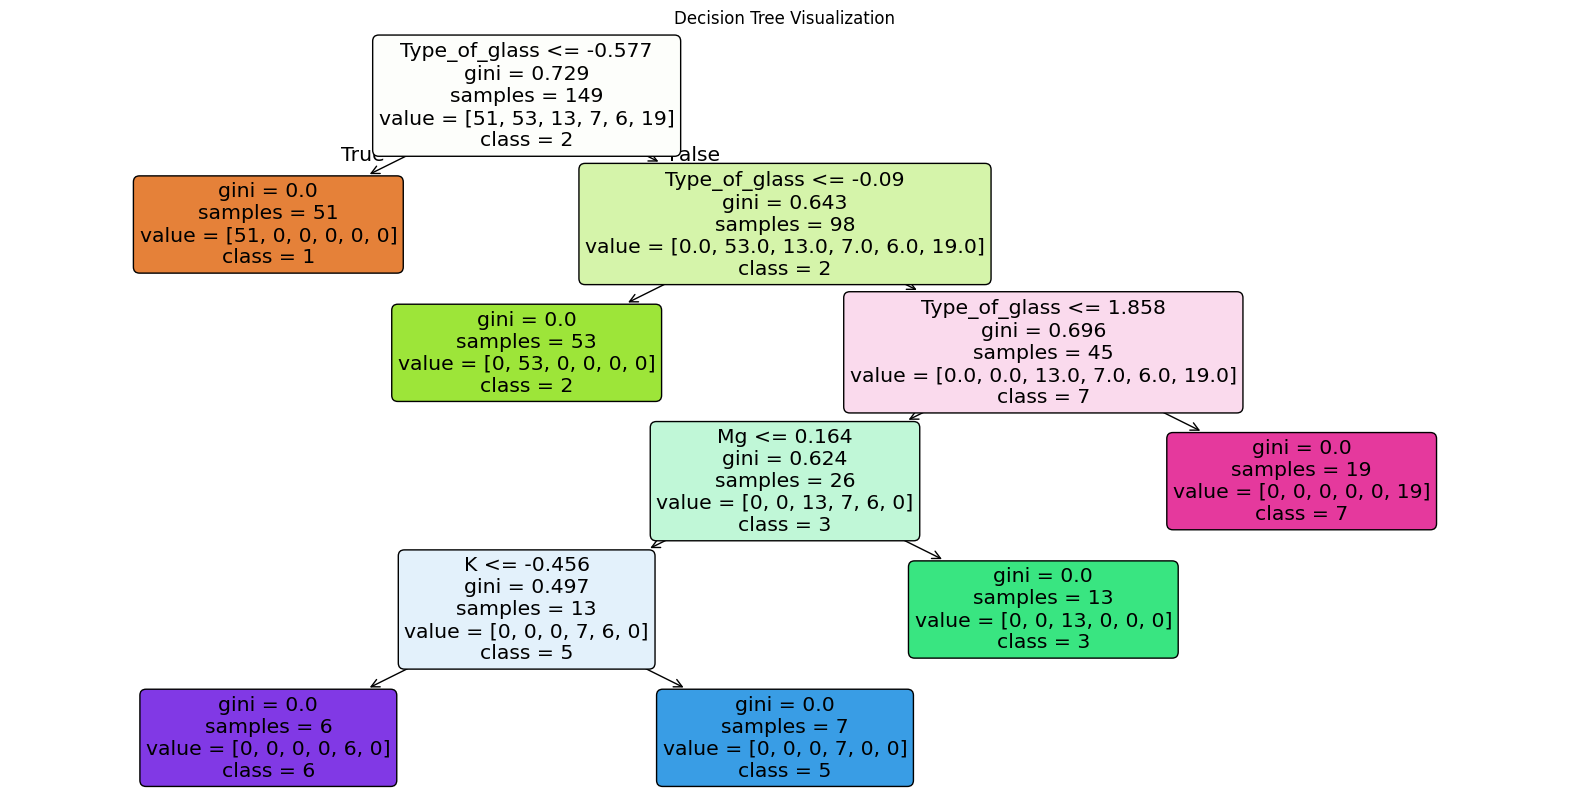

c:\Users\pdkel\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [16]:
def main():
    # Check, clean and explore data
    print("=== Data Quality Check ===")
    data = data_quality_check(pd.concat([X, y], axis=1))
    
    print("\n=== Data Cleaning ===")
    clean_df = clean_data(data)
    
    # Build decision tree model
    dt_model, scaler, feature_names = build_decision_tree(clean_df, clean_df['Type_of_glass'])
    
    # Create GUI
    root = tk.Tk()
    app = GlassIdentifierApp(root, clean_df, dt_model, scaler, feature_names)
    root.mainloop()

if __name__ == "__main__":
    main()